In [1]:
import os

import pandas as pd
import matplotlib.pyplot as plt

from matplotlib_venn import venn2
import itertools as itt
from collections import defaultdict
import logging
import pybel
from pybel.constants import *
from pybel.canonicalize import calculate_canonical_name
import pybel_tools as pbt
from pybel_tools.visualization import to_jupyter
import pybel_tools.analysis.npa as npa

import seaborn as sns

#%config InlineBackend.figure_format = 'svg'
%matplotlib inline

In [2]:
pybel.__version__

'0.4.1'

In [3]:
pbt.__version__

'0.1.3-dev'

In [4]:
bms_base = os.environ['BMS_BASE']
owncloud_base = os.environ['OWNCLOUD_BASE']

## Load

In [5]:
pickle_path = os.path.join(bms_base, 'aetionomy', 'alzheimers.gpickle')

In [6]:
graph = pybel.from_pickle(pickle_path)

## Canonical Mechanisms

In [7]:
canonical_mechanism_names = pbt.summary.get_annotation_values(graph, 'Subgraph')
canonical_mechanism_names 

{'AD T2DM SNPs',
 'ADAM Metallopeptidase subgraph',
 'ATP binding cassette transport subgraph',
 'Acetylcholine signaling subgraph',
 'Akt subgraph',
 'Albumin subgraph',
 'Alcohol dehydrogenase subgraph',
 'Alpha 2 macroglobulin subgraph',
 'Amylin subgraph',
 'Amyloidogenic subgraph',
 'Androgen subgraph',
 'ApoE subgraph',
 'Apoptosis signaling subgraph',
 'Autophagy signaling subgraph',
 'Axonal guidance subgraph',
 'Axonal transport subgraph',
 'Bcl-2 subgraph',
 'Beta secretase subgraph',
 'Beta-Catenin subgraph',
 'Beta-Oxidation of Fatty Acids',
 'Binding and Uptake of Ligands by Scavenger Receptors',
 'Blood vessel dilation subgraph',
 'CREB subgraph',
 'CRH subgraph',
 'Calcium-dependent signal transduction',
 'Calpastatin-calpain subgraph',
 'Calsyntenin subgraph',
 'Caspase subgraph',
 'Cell adhesion subgraph',
 'Cell cycle subgraph',
 'Cell-cell communication subgraph',
 'Chaperone subgraph',
 'Chemokine signaling subgraph',
 'Cholesterol metabolism subgraph',
 'Complement

In [8]:
%%time
canonical_mechanisms = {}
for sg in canonical_mechanism_names:
    m = pbt.selection.get_subgraph_by_annotation(graph, sg)
    canonical_mechanisms[sg] = m

CPU times: user 14.5 s, sys: 72.2 ms, total: 14.6 s
Wall time: 14.7 s


## Generated Mechanisms

In [9]:
bioprocess_nodes = list(pbt.selection.get_nodes_by_function(graph, BIOPROCESS))
len(bioprocess_nodes)

440

In [10]:
%%time
candidate_mechanisms = {}
for bp in bioprocess_nodes:
    m = pbt.generation.generate_mechanism(graph, bp)
    candidate_mechanisms[bp] = m

CPU times: user 3.36 s, sys: 33.2 ms, total: 3.39 s
Wall time: 3.42 s


## Comparison

In [11]:
%%time

results = defaultdict(dict)

for candidate, canonical in itt.product(sorted(candidate_mechanisms), sorted(canonical_mechanisms)):
    candidate_nodes = set(candidate_mechanisms[candidate].nodes_iter())
    canonical_nodes = set(canonical_mechanisms[canonical].nodes_iter())
    tanimoto = pbt.utils.tanimoto_set_similarity(candidate_nodes, canonical_nodes)
    results[canonical][candidate] = tanimoto

df = pd.DataFrame(results)

CPU times: user 4.64 s, sys: 30.8 ms, total: 4.67 s
Wall time: 4.72 s


In [12]:
df.head()

AD T2DM SNPs  \
BiologicalProcess ADO  loss_of_synapses                                 0.00000   
                  GOBP ATP biosynthetic process                         0.00000   
                       B cell differentiation                           0.00000   
                       CD8-positive, alpha-beta T cell activation       0.00000   
                       DNA biosynthetic process                         0.02381   

                                                                   ADAM Metallopeptidase subgraph  \
BiologicalProcess ADO  loss_of_synapses                                                  0.000000   
                  GOBP ATP biosynthetic process                                          0.033898   
                       B cell differentiation                                            0.000000   
                       CD8-positive, alpha-beta T cell activation                        0.000000   
                       DNA biosynthetic process                                          0.080357   

                                                                   ATP binding cassette transport subgraph  \
BiologicalProcess ADO  loss_of_synapses                                                           0.000000   
                  GOBP ATP biosynthetic process                                                   0.037500   
                       B cell differentiation                                                     0.000000   
                       CD8-positive, alpha-beta T cell activation                                 0.000000   
                       DNA biosynthetic process                                                   0.028777   

                                                                   Acetylcholine signaling subgraph  \
BiologicalProcess ADO  loss_of_synapses                                                    0.000000   
                  GOBP ATP biosynthetic process                                            0.013889   
                       B cell differentiation                                              0.000000   
                       CD8-positive, alpha-beta T cell activation                          0.000000   
                       DNA biosynthetic process                                            0.045685   

                                                                   Akt subgraph  \
BiologicalProcess ADO  loss_of_synapses                                0.000000   
                  GOBP ATP biosynthetic process                        0.022222   
                       B cell differentiation                          0.000000   
                       CD8-positive, alpha-beta T cell activation      0.000000   
                       DNA biosynthetic process                        0.048276   

                                                                   Albumin subgraph  \
BiologicalProcess ADO  loss_of_synapses                                         0.0   
                  GOBP ATP biosynthetic process                                 0.0   
                       B cell differentiation                                   0.0   
                       CD8-positive, alpha-beta T cell activation               0.0   
                       DNA biosynthetic process                                 0.0   

                                                                   Alcohol dehydrogenase subgraph  \
BiologicalProcess ADO  loss_of_synapses                                                  0.000000   
                  GOBP ATP biosynthetic process                                          0.062500   
                       B cell differentiation                                            0.000000   
                       CD8-positive, alpha-beta T cell activation                        0.000000   
                       DNA biosynthetic process                                          0.013158   

                                                    

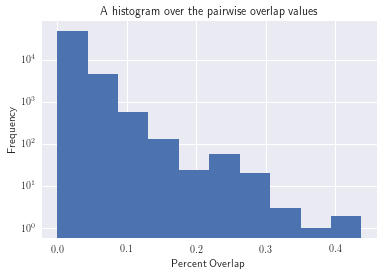

In [40]:
plt.title('A histogram over the pairwise overlap values')
plt.xlabel('Percent Overlap')
plt.ylabel('Frequency')
plt.hist(df.as_matrix().ravel(), log=True)
plt.show()

In [13]:
df.to_csv(os.path.expanduser('~/Desktop/subgraph_comparison.csv'))

/usr/local/lib/python3.6/site-packages/matplotlib/cbook.py:136: MatplotlibDeprecationWarning: The axisbg attribute was deprecated in version 2.0. Use facecolor instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


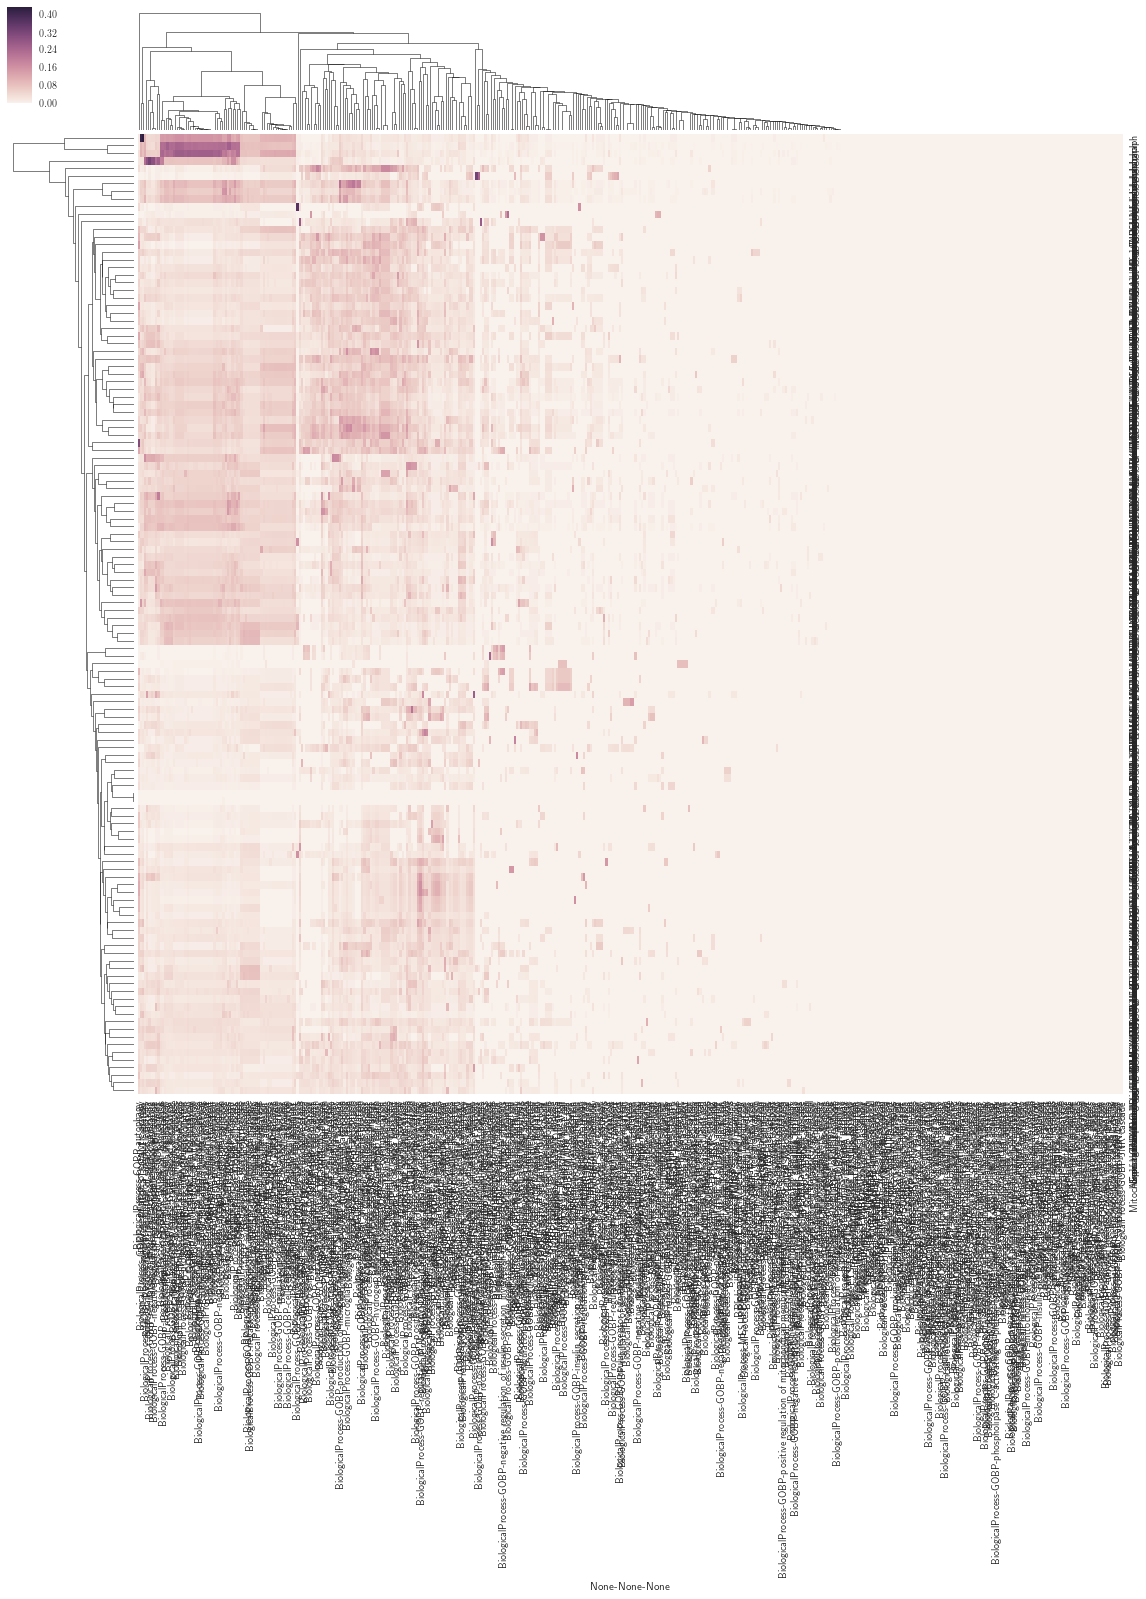

In [23]:
sns.clustermap(df.T, figsize=(20, 20))
plt.show()